In [23]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns


### To-do list: 
- Smooth data 4mm kernel -> Done. 
- See if I need to trim the offset of each func file.
- Data appears to have 378 vol points and 756 time points. However, some trailers start appearing untile sec 777.
- Try using clean_img(). 

# Homemade functions

In [24]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

In [25]:
# Define a function to invert scores if needed. 
def invert_score(score):
    if(score == 1):  
        return 4
    elif(score == 2):  
        return 3
    elif(score == 3):  
        return 2
    elif(score == 4):  
        return 1
    else: 
        return "Something went wrong here!"
      

In [26]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [27]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        trailer_watch_score = run_dataframe["exp_Watch.keys"][id].astype(int)
        trailer_arousal_score = run_dataframe["exp_Arousal.keys"][id].astype(int)
        trailer_feel_score = run_dataframe["exp_Feel.keys"][id].astype(int)

        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        if(run_dataframe["scale_flip"][id] == 0):
            trailer_watch_score = run_dataframe["exp_Watch.keys"].apply(invert_score)[id].astype(int)
            trailer_arousal_score = run_dataframe["exp_Arousal.keys"].apply(invert_score)[id].astype(int)
            trailer_feel_score = run_dataframe["exp_Feel.keys"].apply(invert_score)[id].astype(int)
        
        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    return proccesed_events_df

In [28]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


## Load func files for Sub-03 run 1. 

In [29]:
# Load files for sub 001  
sub03_run1_func_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub03_run2_func_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

sub03_run1_mask_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub03_run2_mask_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

sub03_run1_events_path = 'MovieData_BIDS_raw/sub-03/func/sub-03_task-movie_run-01_events.csv'
sub03_run2_events_path = 'MovieData_BIDS_raw/sub-03/func/sub-03_task-movie_run-02_events.csv'

sub03_run1_confounds_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-01_desc-confounds_timeseries.tsv"
sub03_run2_confounds_path = "MovieData_BIDS_preproc/sub-03/func/sub-03_task-movie_run-01_desc-confounds_timeseries.tsv"


In [30]:
# Calculate mean image to use as background image.
fmri_img = concat_imgs(sub03_run1_func_path)
mean_img = mean_img(fmri_img)

func_file = nib.load(sub03_run1_func_path)
func_data = func_file.get_fdata()

# Calculate relevant parameters for GLM and ROI time-course analysis.
n_vols = func_data.shape[3]
TR = 2
n_timepoints = n_vols*TR

print("Sub-03 run 1 contains %s" % str(n_timepoints) + " time points.")
print("Sub-03 run 1 contains %s" % str(n_vols) + " vols.")

Sub-03 run 1 contains 756 time points.
Sub-03 run 1 contains 378 vols.


# Process behavioral data. 

In [31]:
sub03_run1_events_df = pd.read_csv(sub03_run1_events_path, index_col=0)
sub03_run2_events_df = pd.read_csv(sub03_run2_events_path, index_col=0)

sub03_run1_events_df.head(20)

,participant,expName,label,released,trial_ITI,scale_flip,sound_trailer.started,sound_trailer.stopped,exp_WatchQ.started,exp_WatchQ.stopped,exp_Watch.keys,exp_FeelQ.started,exp_FeelQ.stopped,exp_Feel.keys,exp_Arousal.started,exp_Arousal.stopped,exp_Arousal.keys
0,ah231215,fmritrailer_run2,rh6,1.0,6.0,0.0,117.635831,None,147.735315,151.746823,2.0,151.665969,155.742751,3.0,155.694630,None,2.0
1,ah231215,fmritrailer_run2,uh1,0.0,6.0,1.0,165.619540,195.674011805997,195.674012,199.707160,4.0,199.671155,203.766015,3.0,203.715461,None,2.0
2,ah231215,fmritrailer_run2,rc2,1.0,6.0,1.0,213.670337,None,243.700427,247.733517,4.0,247.669639,251.747882,3.0,251.700221,None,4.0
3,ah231215,fmritrailer_run2,rh2,1.0,2.0,0.0,261.700535,291.73323982799775,291.733240,295.767502,3.0,295.728788,299.813911,3.0,299.749913,None,2.0
4,ah231215,fmritrailer_run2,rh1,1.0,2.0,1.0,305.714593,335.7568738730042,335.756874,339.765825,3.0,339.743652,343.783202,3.0,343.783202,None,2.0
5,ah231215,fmritrailer_run2,rc9,1.0,6.0,0.0,349.721753,None,379.755897,383.787692,3.0,383.764349,387.780805,4.0,387.747459,None,3.0
6,ah231215,fmritrailer_run2,uc4,0.0,2.0,0.0,397.749807,None,427.767757,431.827877,3.0,431.780320,435.812748,4.0,435.746831,None,3.0
7,ah231215,fmritrailer_run2,rh9,1.0,2.0,0.0,441.780005,471.7951010569959,471.795101,475.834535,2.0,475.809778,479.841190,2.0,479.808730,None,2.0
8,ah231215,fmritrailer_run2,uh2,0.0,2.0,1.0,485.798951,515.8166230719944,515.796498,519.806642,4.0,519.806642,523.845952,4.0,523.819513,None,3.0
9,ah231215,fmritrailer_run2,rc6,1.0,2.0,1.0,529.784136,559.8125010149961,559.795409,563.812359,2.0,563.812359,567.863882,1.0,567.830626,None,2.0


In [32]:
sub03_run1_p_events = process_events_data(sub03_run1_events_df)
sub03_run2_p_events = process_events_data(sub03_run2_events_df)

sub03_run1_p_events.head(16)

,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score
0,rh6,Horror,12,42,30,3,3,2
1,uh1,Horror,60.0,90.0,30,4,2,3
2,rc2,Comedy,108.0,138.0,30,4,4,3
3,rh2,Horror,152.0,182.0,30,2,3,2
4,rh1,Horror,196.0,226.0,30,3,2,3
5,rc9,Comedy,244.0,274.0,30,2,2,1
6,uc4,Comedy,288.0,318.0,30,2,2,1
7,rh9,Horror,332.0,362.0,30,3,3,3
8,uh2,Horror,376.0,406.0,30,4,3,4
9,rc6,Comedy,420.0,450.0,30,2,2,1


In [33]:
sub03_run2_p_events.head(16)

,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score
0,rc3,Comedy,12,42,30,1,2,1
1,rh12,Horror,60.0,90.0,30,4,2,4
2,rc1,Comedy,108.0,138.0,30,2,3,1
3,rh7,Horror,152.0,182.0,30,4,2,4
4,rc8,Comedy,200.0,230.0,30,3,4,2
5,uc3,Comedy,244.0,274.0,30,1,2,1
6,rh10,Horror,288.0,318.0,30,4,2,4
7,rc4,Comedy,332.0,362.0,30,1,1,1
8,rh4,Horror,380.0,410.0,30,4,2,4
9,uc2,Comedy,428.0,458.0,30,1,3,2


# Slice func files to each trailer onset-duration. 

In [34]:
# Down-sample predictors to get vol onsets. 

# Create array from 0 to 'n_timepoints' in steps of 1.
time_scale = np.arange(0, n_timepoints, 1)  
print("Time_scale scale has %i datapoints" % time_scale.size)

# Create array from 0 to 'n_timepoints' in steps of 2.
vol_scale = np.arange(0, n_timepoints, TR)  
print("Vol scale has %i datapoints" % vol_scale.size)

# Get the labels of each trailer for each run. 
run1_trailer_labels = sub03_run1_p_events["Trailer"].tolist()
run2_trailer_labels = sub03_run2_p_events["Trailer"].tolist()

# Create dictionary variable to store arrays with onset values for each trailer. 
run1_onsets = {}
run2_onsets = {}

# Create a dictionary with all the onsets for each trailer in each run. 
for id in range(len(run1_trailer_labels)):

    #print("Running trailer: " + str(id))
    # Create array of zeros.
    run1_trailer_onsets = np.zeros(n_timepoints)
    run2_trailer_onsets = np.zeros(n_timepoints)

    # Get onset time. 
    run1_current_trailer_onset = sub03_run1_p_events["Onset"][id]
    run2_current_trailer_onset = sub03_run2_p_events["Onset"][id]

    # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
    # Adjust for lag: add 4 seconds at the onset and offset
    run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
    run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1

    # Create resampler objects for each trailer/run of reward.
    run1_resampler = interp1d(time_scale, run1_trailer_onsets)
    run2_resampler = interp1d(time_scale, run2_trailer_onsets)

    # Create downsampled arrays for each trailer. 
    # Note this vol arrays are half the length than the time arrays.
    run1_trailer_vol_onsets = run1_resampler(vol_scale)
    run2_trailer_vol_onsets = run2_resampler(vol_scale)

    # Append/store the downsampled volumes arrays to each dictionary.
    # I'm doing it this way, so the code is more interpretable
    run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
    run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets


Time_scale scale has 756 datapoints
Vol scale has 378 datapoints


# Load confounds

In [35]:
# Load confounds file for sub001 run 1. 
sub03_run1_confounds_df = pd.read_csv(sub03_run1_confounds_path, sep='\t')
sub03_run2_confounds_df = pd.read_csv(sub03_run2_confounds_path, sep='\t')
default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor"]

# Add confound columns if they contain 'state' in the title. 
sub03_run1_motion_s_confounds = [i for i in sub03_run1_confounds_df.columns if "motion" in i] #"motion"
sub03_run2_motion_s_confounds = [i for i in sub03_run2_confounds_df.columns if "motion" in i] 

sub03_run1_motion_rot_confounds = [i for i in sub03_run1_confounds_df.columns if "rot" in i] 
sub03_run2_motion_rot_confounds = [i for i in sub03_run2_confounds_df.columns if "rot" in i] 

sub03_run1_motion_trans_confounds = [i for i in sub03_run1_confounds_df.columns if "trans" in i] 
sub03_run2_motion_trans_confounds = [i for i in sub03_run2_confounds_df.columns if "trans" in i] 

sub03_run1_motion_cos_confounds = [i for i in sub03_run1_confounds_df.columns if "cos" in i] 
sub03_run2_motion_cos_confounds = [i for i in sub03_run2_confounds_df.columns if "cos" in i] 

sub03_run1_filtered_confounds_df = sub03_run1_confounds_df[default_confounds + sub03_run1_motion_s_confounds + sub03_run1_motion_rot_confounds + sub03_run1_motion_trans_confounds ]
sub03_run2_filtered_confounds_df = sub03_run2_confounds_df[default_confounds + sub03_run2_motion_s_confounds + sub03_run2_motion_rot_confounds + sub03_run2_motion_trans_confounds ]

# Change NaNs to 0s. 
sub03_run1_filtered_confounds_df = sub03_run1_filtered_confounds_df.fillna(0) 
sub03_run2_filtered_confounds_df = sub03_run2_filtered_confounds_df.fillna(0) 
sub03_run1_filtered_confounds_df.head()

,white_matter,csf,csf_wm,framewise_displacement,dvars,rmsd,tcompcor,motion_outlier00,motion_outlier01,rot_x,...,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,trans_y_derivative1_power2,trans_y_power2,trans_z,trans_z_derivative1,trans_z_power2,trans_z_derivative1_power2
0,3992.553458,6695.666681,4182.842665,0.000000,0.000000,0.000000,5201.536099,0.0,0.0,-0.000413,...,1.157195e-04,0.000000,-0.000009,0.000000,0.000000,8.740399e-11,-0.080162,0.000000,0.006426,0.000000
1,3510.484566,3149.107057,3416.616607,0.455560,339.184845,0.324236,3637.053525,1.0,0.0,-0.000515,...,1.773345e-09,0.000117,-0.031245,-0.031236,0.000976,9.762625e-04,0.228605,0.308767,0.052260,0.095337
2,3497.475596,3185.547266,3412.433929,0.152368,29.457405,0.105873,3567.562500,0.0,1.0,-0.000511,...,3.843132e-05,0.000039,-0.060796,-0.029550,0.000873,3.696105e-03,0.328923,0.100318,0.108190,0.010064
3,3494.525344,3126.151065,3405.463166,0.049400,13.949973,0.021791,3548.010671,0.0,0.0,-0.000511,...,2.847960e-04,0.000114,-0.046815,0.013981,0.000195,2.191607e-03,0.319505,-0.009418,0.102083,0.000089
4,3491.878433,3095.246374,3401.931323,0.070642,14.441262,0.042465,3485.162203,0.0,0.0,-0.000511,...,2.515967e-04,0.000001,-0.060792,-0.013978,0.000195,3.695692e-03,0.357640,0.038135,0.127906,0.001454


# Apply spatial smoothing to data. 

In [36]:
# Applying a Gaussian filter with a 4mm kernel

#sub03_run1_func_smooth = smooth_img(sub03_run1_func_path, 4)
#sub03_run2_func_smooth = smooth_img(sub03_run2_func_path, 4)



# Use Sphere Mask on NAcc. 

In [37]:
# Init the sphere masking object. 
# Note, I am using to seeds one for right and one for left NAcc. 
# The sphere has a radius of 8 mm. 
# I'm filtering out both high an low frequencies. 
masker_sNAcc_r1 = NiftiSpheresMasker(
    seeds=[(10, 12, -2), (-10, 12, -2)],  # right, left
    smoothing_fwhm=4,
    radius=8, 
    mask_img=sub03_run1_mask_path,
    standardize="psc", 
    detrend=False,
    t_r=2,
    standardize_confounds="psc",
    #standardize="zscore",
    #standardize_confounds="zscore",
    high_pass=1/360, # High cutoff frequency in Hertz.
    low_pass=0.1 # from 1.0
    )

masker_sNAcc_r2 = NiftiSpheresMasker(
    seeds=[(10, 12, -2), (-10, 12, -2)],  # right, left
    smoothing_fwhm=4,
    radius=8, 
    mask_img=sub03_run2_mask_path,
    standardize="psc", 
    detrend=False,
    t_r=2,
    standardize_confounds="psc", # Why, though?
    #standardize="zscore",
    #standardize_confounds="zscore",
    high_pass=1/360, # High cutoff frequency in Hertz.
    low_pass=0.1 # from 1.0
    )

# Mask the epi data and get a time series for the ROI. 
# Note this is similar to fitting the GLM, but without the event files.
sub03_r1_bNAcc = masker_sNAcc_r1.fit_transform(sub03_run1_func_path, confounds=sub03_run1_filtered_confounds_df)
sub03_r2_bNAcc = masker_sNAcc_r2.fit_transform(sub03_run2_func_path, confounds=sub03_run2_filtered_confounds_df)

# Apply function to get the percent signal change from each ROI timecourse. 
sub03_r1_bNAcc_psc = get_psc(sub03_r1_bNAcc)
sub03_r2_bNAcc_psc = get_psc(sub03_r2_bNAcc)

print("Sub03 run 1 bilateral NAcc timecourse has the following shape: %s" % str(sub03_r1_bNAcc.shape))
print("Sub03 run 2 bilateral NAcc timecourse has the following shape: %s" % str(sub03_r2_bNAcc.shape))

Sub03 run 1 bilateral NAcc timecourse has the following shape: (378, 2)
Sub03 run 2 bilateral NAcc timecourse has the following shape: (378, 2)


In [38]:


# Get number of ROIs and data points in timecourse.
roi_num = sub03_r1_bNAcc.shape[1]
data_length = sub03_r1_bNAcc.shape[0]

# Copy timecourse into new array.
psc_timecourse_test = np.zeros(sub03_r1_bNAcc.shape)

# Loop through every ROI and derive the psc. 
for id in range(roi_num):

    current_roi_avg = np.mean(sub03_r1_bNAcc[:, id], axis=0)
    print("Current ROI average is: %s" % current_roi_avg)

    for idx in range(data_length):

        # Formula to get percent signal change -> ((point-avg)/avg)*100.
        psc_timecourse_test[idx, id] = ((sub03_r1_bNAcc[idx, id] - current_roi_avg)/ current_roi_avg)*100



Current ROI average is: -2.5201622094298742e-14
Current ROI average is: -2.883290314322814e-14


Text(0.5, 1.0, 'Sub-03 Rigth NAcc psc time course activity for whole run 1.')

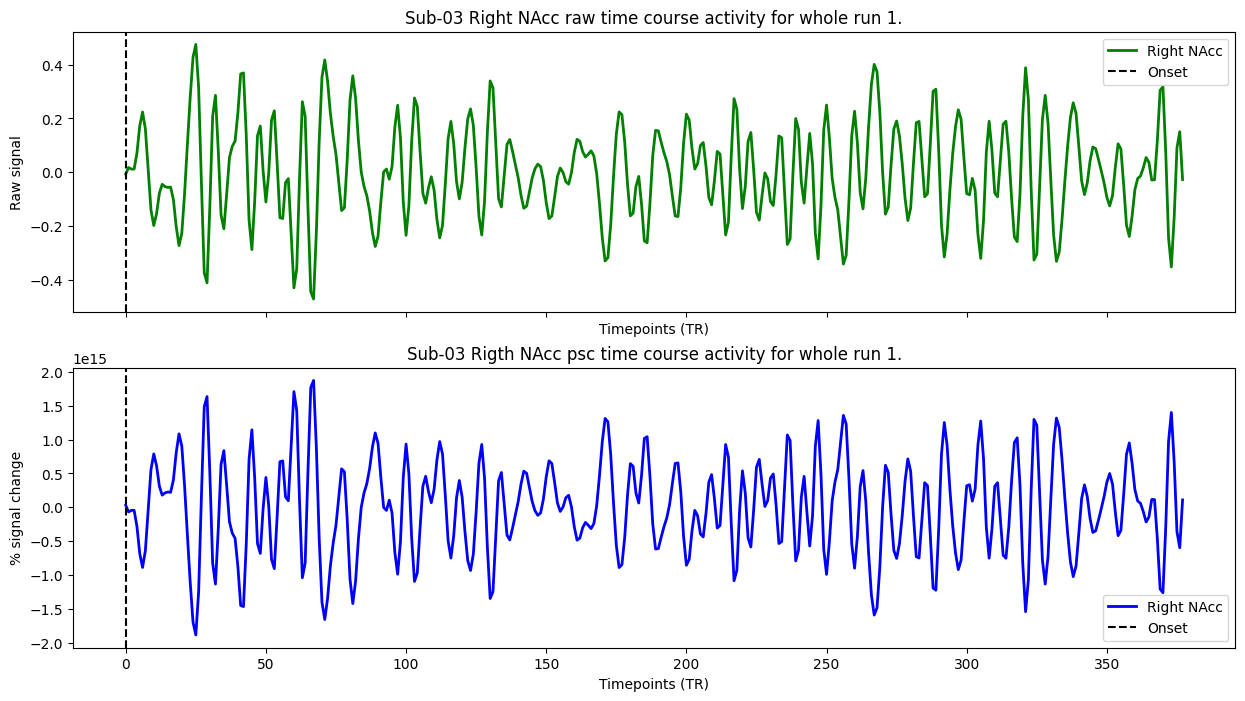

In [39]:
# Plot the whole time course for the ROI and run. 

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

axs[0].plot(sub03_r1_bNAcc[:, 0], 'g', lw=2, label="Right NAcc")
#axs[id, 0].plot(run1_timeseries[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
#axs[id, 0].plot(run1_timeseries[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
axs[0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
axs[0].legend()
axs[0].set_ylabel('Raw signal')
axs[0].set_xlabel('Timepoints (TR)')
axs[0].set_title("Sub-03 Right NAcc raw time course activity for whole run 1.")
#axs[0].set_ylim(-40, 40)

axs[1].plot(psc_timecourse_test[:, 0], 'b', lw=2, label="Right NAcc")
#axs[1].plot(run1_timeseries[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
#axs[1].plot(run1_timeseries[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
axs[1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
axs[1].legend()
axs[1].set_ylabel('% signal change')
axs[1].set_xlabel('Timepoints (TR)')
axs[1].set_title("Sub-03 Rigth NAcc psc time course activity for whole run 1.")
#axs[1].set_ylim(-40, 40)


In [40]:

print("sub03_r1_bNAcc right NAcc min value: %s" % str(np.min(sub03_r1_bNAcc[:, 0])))
print("sub03_r1_bNAcc right NAcc max value: %s" % str(np.max(sub03_r1_bNAcc[:, 0])))
print("sub03_r1_bNAcc right NAcc mean value: %s" % str(np.mean(sub03_r1_bNAcc[:, 0])))
print("sub03_r1_bNAcc right NAcc std value: %s" % str(np.std(sub03_r1_bNAcc[:, 0])))

print("\nsub03_r2_bNAcc right NAcc min value: %s" % str(np.min(sub03_r2_bNAcc[:, 0])))
print("sub03_r2_bNAcc right NAcc max value: %s" % str(np.max(sub03_r2_bNAcc[:, 0])))
print("sub03_r2_bNAcc right NAcc mean value: %s" % str(np.mean(sub03_r2_bNAcc[:, 0])))
print("sub03_r2_bNAcc right NAcc std value: %s" % str(np.std(sub03_r2_bNAcc[:, 0])))

print("\nsub03_r1_bNAcc_psc right NAcc min value: %s" % str(np.min(sub03_r1_bNAcc_psc[:, 0])))
print("sub03_r1_bNAcc_psc right NAcc max value: %s" % str(np.max(sub03_r1_bNAcc_psc[:, 0])))
print("sub03_r1_bNAcc_psc right NAcc mean value: %s" % str(np.mean(sub03_r1_bNAcc_psc[:, 0])))
print("sub03_r1_bNAcc_psc right NAcc std value: %s" % str(np.std(sub03_r1_bNAcc_psc[:, 0])))

print("\nsub03_r2_bNAcc_psc right NAcc min value: %s" % str(np.min(sub03_r2_bNAcc_psc[:, 0])))
print("sub03_r2_bNAcc_psc right NAcc max value: %s" % str(np.max(sub03_r2_bNAcc_psc[:, 0])))
print("sub03_r2_bNAcc_psc right NAcc mean value: %s" % str(np.mean(sub03_r2_bNAcc_psc[:, 0])))
print("sub03_r2_bNAcc_psc right NAcc std value: %s" % str(np.std(sub03_r2_bNAcc_psc[:, 0])))



sub03_r1_bNAcc right NAcc min value: -0.4722039793068906
sub03_r1_bNAcc right NAcc max value: 0.47540110748858977
sub03_r1_bNAcc right NAcc mean value: -2.5201622094298742e-14
sub03_r1_bNAcc right NAcc std value: 0.173723305281133

sub03_r2_bNAcc right NAcc min value: -0.6813284850991811
sub03_r2_bNAcc right NAcc max value: 0.6035640526518278
sub03_r2_bNAcc right NAcc mean value: -5.455718181750584e-14
sub03_r2_bNAcc right NAcc std value: 0.2114189702238445

sub03_r1_bNAcc_psc right NAcc min value: -1886390906544714.0
sub03_r1_bNAcc_psc right NAcc max value: 1873704706546211.2
sub03_r1_bNAcc_psc right NAcc mean value: 0.006283068783068783
sub03_r1_bNAcc_psc right NAcc std value: 689333823954267.2

sub03_r2_bNAcc_psc right NAcc min value: -1106296242849948.5
sub03_r2_bNAcc_psc right NAcc max value: 1248833723446667.8
sub03_r2_bNAcc_psc right NAcc mean value: -0.008597883597883597
sub03_r2_bNAcc_psc right NAcc std value: 387518129017445.3


# Derive ROI time courses for each Movie trailer. 

In [41]:

# Extract segments based stimulus onsets. 

# Create dictionary variable to store arrays with time series arrays for each trailer. 
run1_timeseries = {}
run2_timeseries = {}

# Get the trailers presented in each run. 
r1_keys = list(run1_onsets.keys())
r2_keys = list(run2_onsets.keys())
print("Run 1 presented the following trailers: %s" % str(r1_keys))
print("Run 2 presented the following trailers: %s" % str(r2_keys))

# Loop through each traile and get its corresponding ROI timecourse
# from bilateral, left, and right, NAcc.
for id in range(len(r1_keys)):

    run1_timeseries[r1_keys[id]] = {
        "Bilateral_NAcc": np.mean(sub03_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, :], axis=1),
        "Left_NAcc": sub03_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
        "Right_NAcc": sub03_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, 0]}
    
    run2_timeseries[r2_keys[id]] = {
        "Bilateral_NAcc": np.mean(sub03_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, :], axis=1),
        "Left_NAcc": sub03_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
        "Right_NAcc": sub03_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, 0]}





Run 1 presented the following trailers: ['rh6', 'uh1', 'rc2', 'rh2', 'rh1', 'rc9', 'uc4', 'rh9', 'uh2', 'rc6', 'rh3', 'rc11', 'uc1', 'rh11', 'rc12', 'rc5']
Run 2 presented the following trailers: ['rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'uc3', 'rh10', 'rc4', 'rh4', 'uc2', 'rh5', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']


# Plot NAcc time courses from Sub-03.

In [42]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rc3', 'rh12',
                  'rc1', 'rh7',
                  'rc8', 'rh10',
                  'uc3', 'rh4',
                  'rc4', 'rh5',
                  'uc2', 'rh8',
                  'rc10', 'uh3',
                  'rc7', 'uh4']


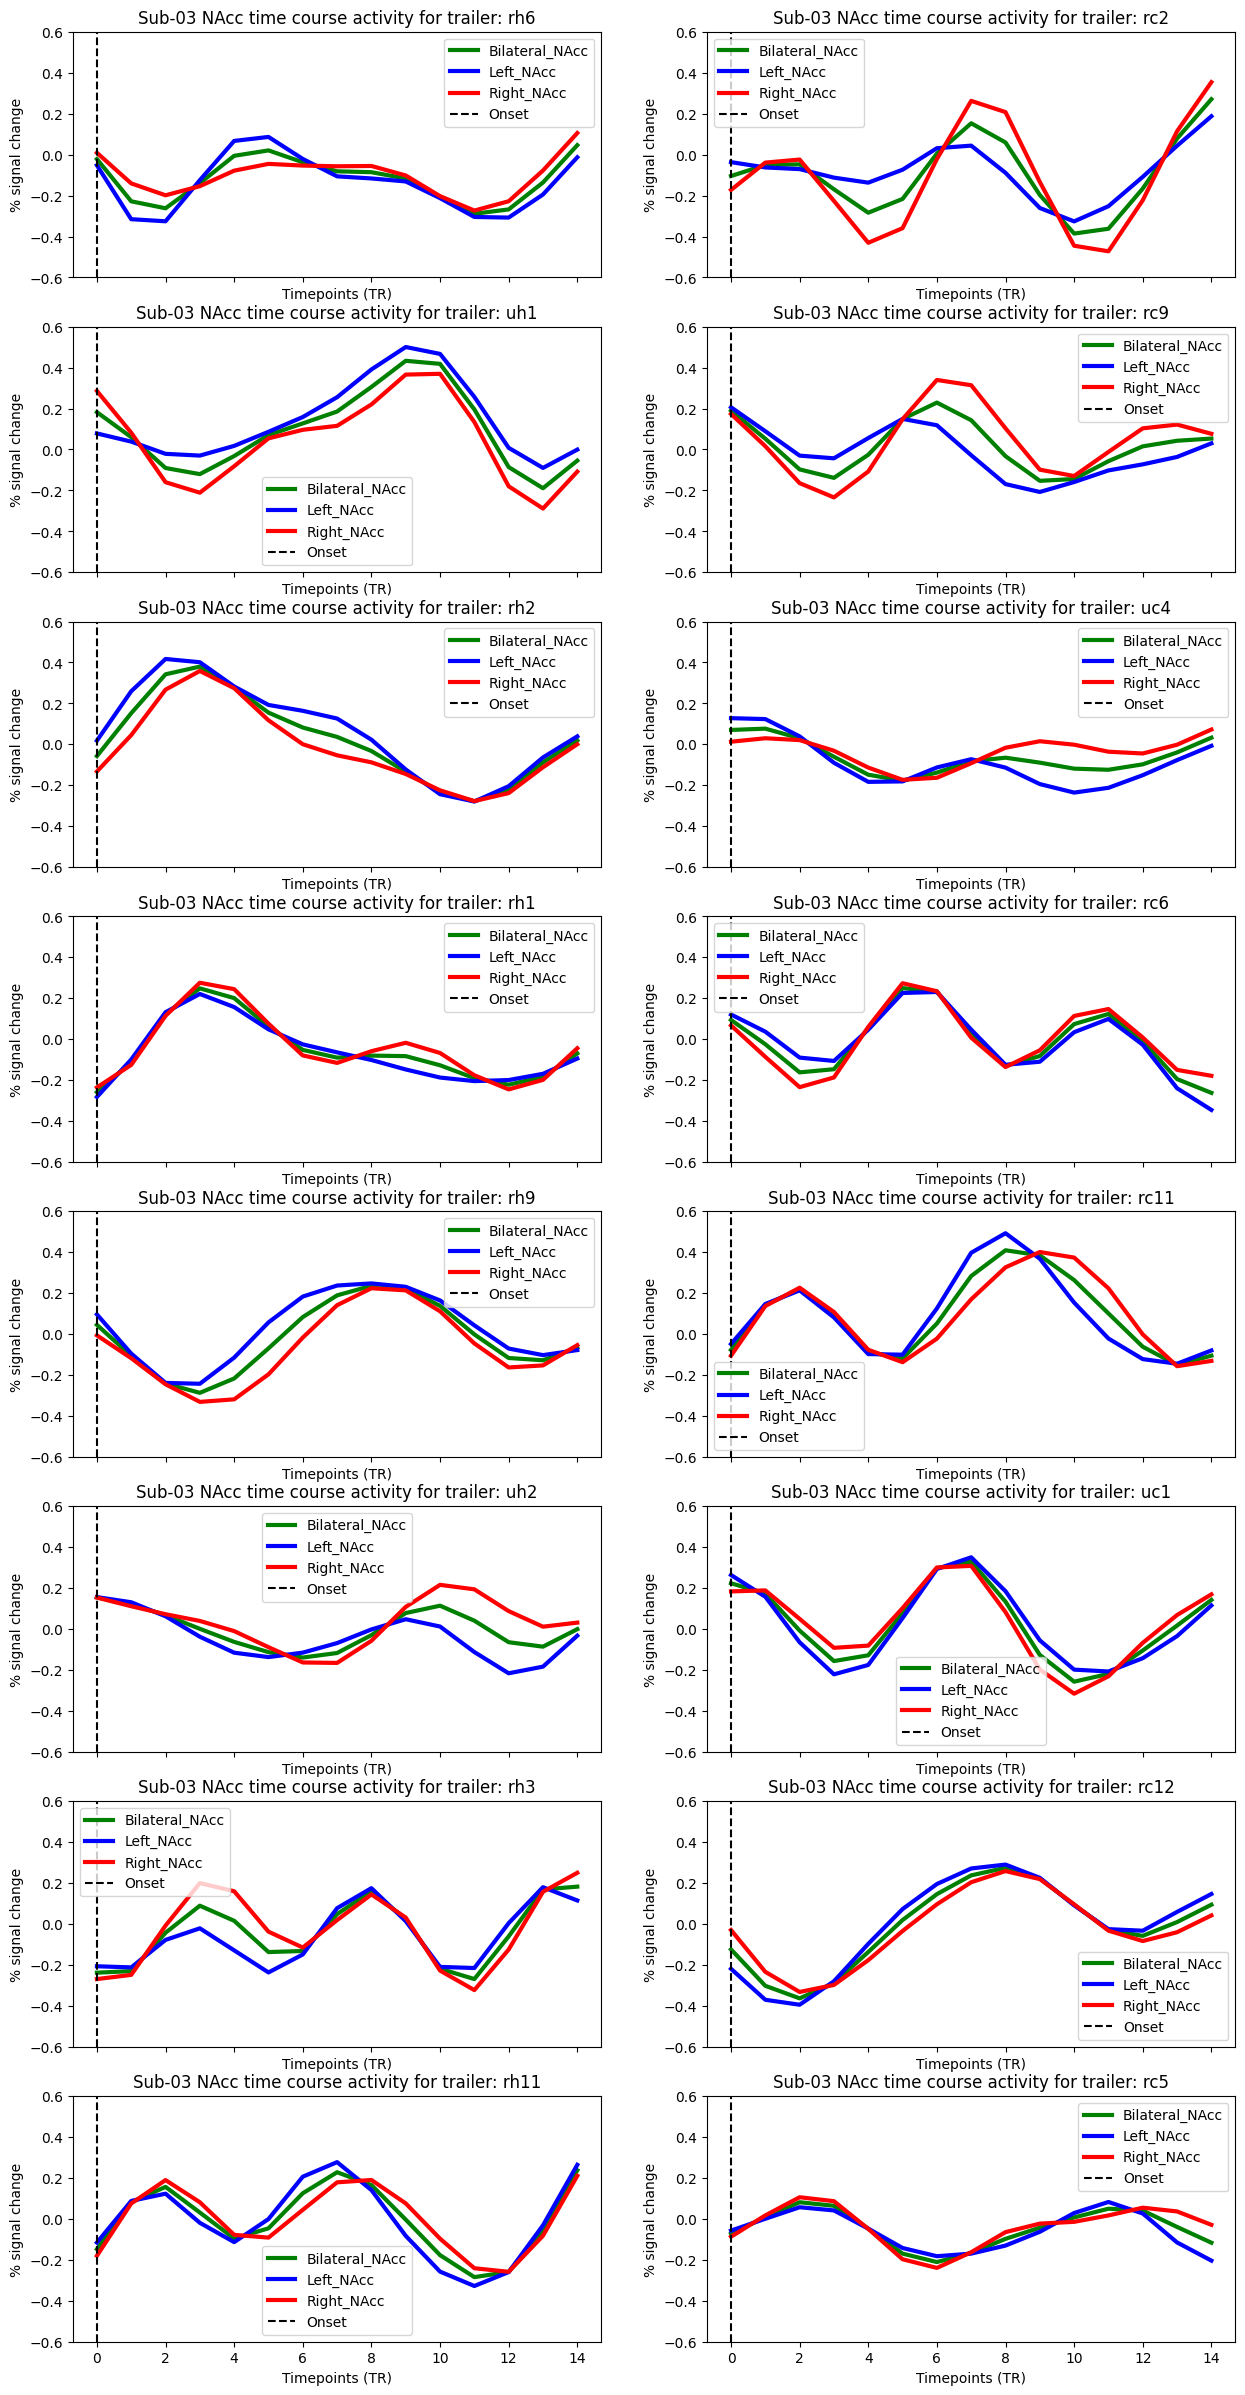

In [45]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    axs[id, 0].plot(run1_timeseries[r1_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 0].plot(run1_timeseries[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 0].plot(run1_timeseries[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 0].legend()
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_title("Sub-03 NAcc time course activity for trailer: " + str(r1_keys_sorted[runner]))
    axs[id, 0].set_ylim(-.6, .6)

    runner +=1

    axs[id, 1].plot(run1_timeseries[r1_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 1].plot(run1_timeseries[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 1].plot(run1_timeseries[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 1].legend()
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_title("Sub-03 NAcc time course activity for trailer: " + str(r1_keys_sorted[runner]))
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1


 



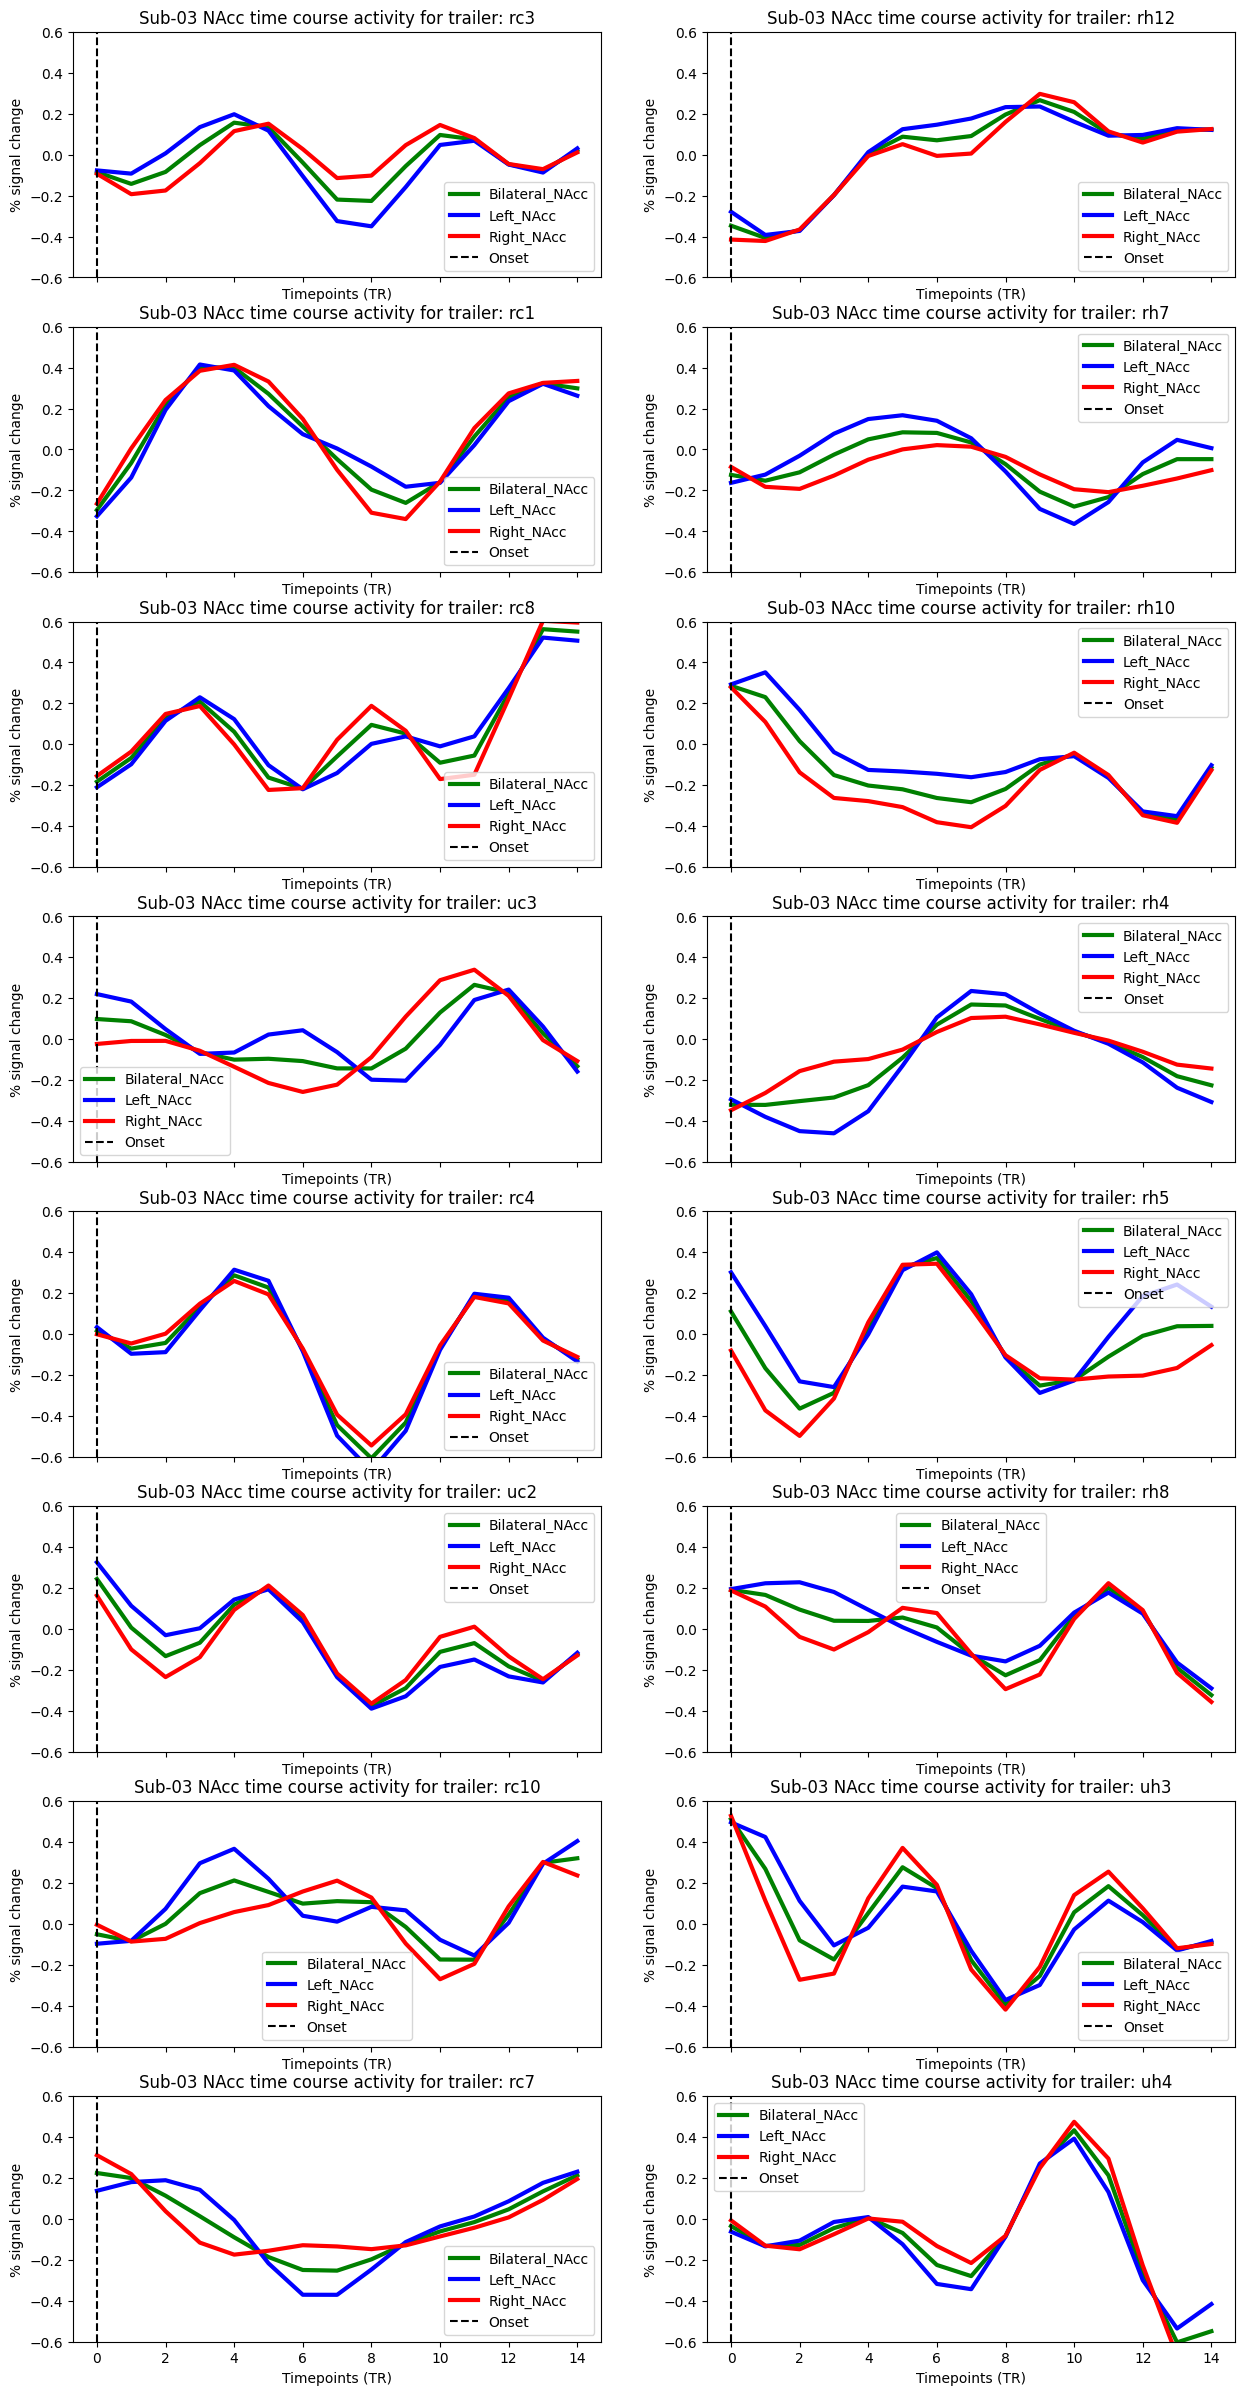

In [46]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    axs[id, 0].plot(run2_timeseries[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 0].plot(run2_timeseries[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 0].plot(run2_timeseries[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 0].legend()
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_title("Sub-03 NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 0].set_ylim(-.6, .6)

    runner +=1

    axs[id, 1].plot(run2_timeseries[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 1].plot(run2_timeseries[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 1].plot(run2_timeseries[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 1].legend()
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_title("Sub-03 NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1
